# Convolutional Neural Network - MNIST

Make Your First GAN With PyTorch, 2020

In [1]:
# mount Drive to access data files



In [2]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

from PIL import Image

# Helper Functions

In [3]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

## DataSet Class

In [4]:
# dataset class

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass


## Load Data

In [5]:
mnist_dataset = MnistDataset(r'../../../dataset/mnist_dataset/mnist_train.csv')

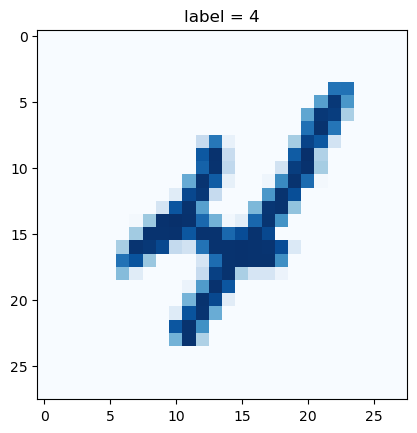

In [6]:
# check data contains images

mnist_dataset.plot_image(9)

## Neural Network Class

In [7]:
# classifier class

class Classifier(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Conv2d(1, 10, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
        
            # 10 filters to 10 filters
            nn.Conv2d(10, 10, kernel_size=3, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            
            View(250),
            nn.Linear(250, 10),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters())

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward_train(self, inputs):
        # simply run model
        return self.model(inputs)
        
    def forward(self, inputs):
        # simply run model
        return self.model(inputs).unsqueeze(0)
    
    
    def train_classifier(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward_train(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## Train Neural Network

In [8]:
%%time 
# create neural network

C = Classifier()

# train network on MNIST data set

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train_classifier(image_data_tensor.view(1, 1, 28, 28), target_tensor)
        pass
    pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 1min 40s, sys: 1min, total: 2min 40s
Wall time: 2min 2s


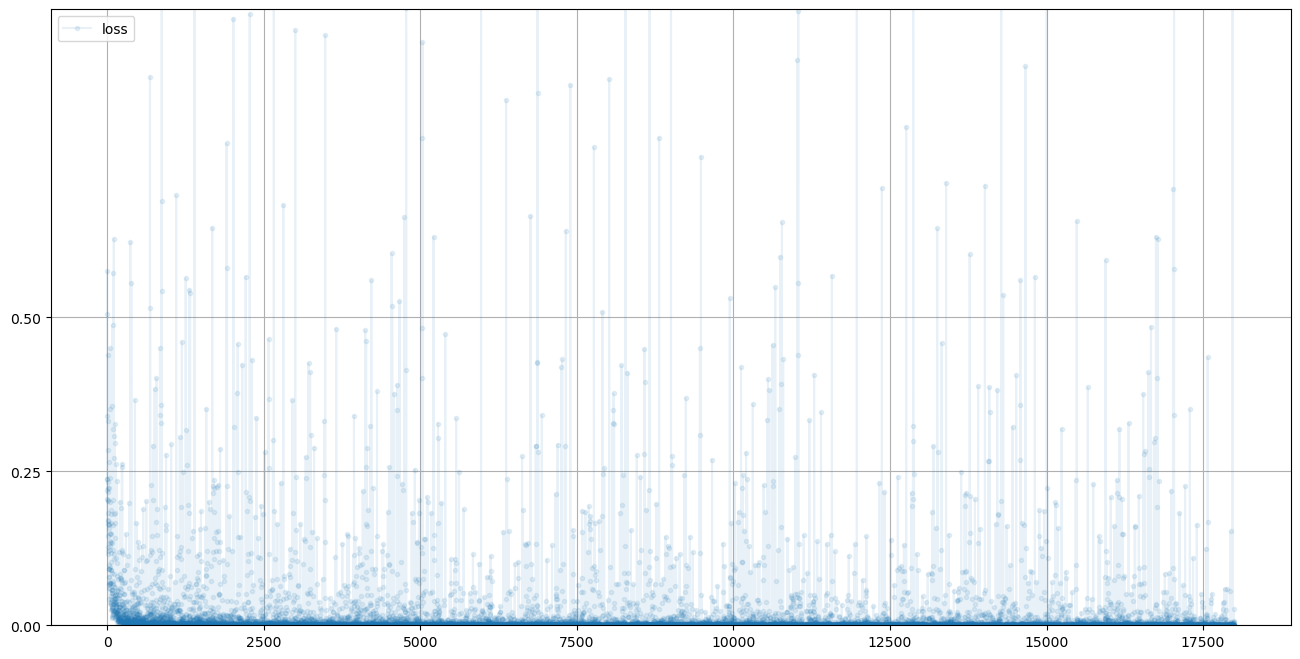

In [9]:
# plot classifier error

C.plot_progress()

## Classification Example

In [10]:
# load MNIST test data

mnist_test_dataset = MnistDataset(r'../../../dataset/mnist_dataset/mnist_test.csv')

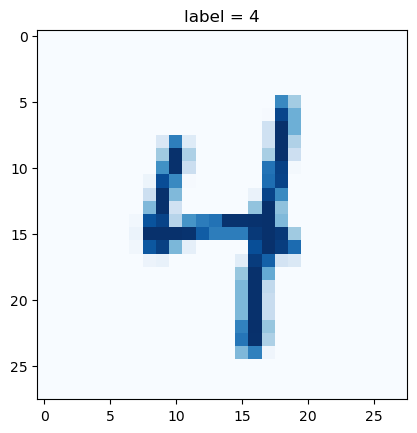

In [11]:
# pick a record
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)

tensor([1.4044e-09, 7.8953e-07, 5.2849e-06, 3.2771e-05, 1.0000e+00, 2.7818e-05,
        1.6102e-09, 3.6191e-05, 6.6524e-07, 2.6603e-06],
       grad_fn=<SigmoidBackward0>)


<Axes: >

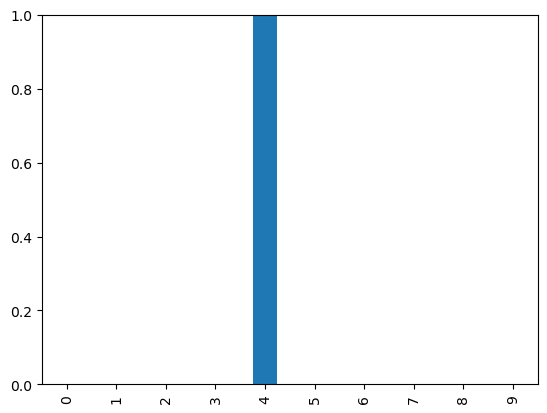

In [12]:
# visualise the answer given by the neural network

image_data = mnist_test_dataset[record][1]

# query from trained network
output = C.forward_train(image_data.view(1,1,28,28))

print(output)

# plot output tensor
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

## Classifier Performance

In [13]:
# test trained neural network on training data

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward_train(image_data_tensor.view(1,1,28,28)).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

9806 10000 0.9806


## DeepFool Test

-----------------------
Iteration 0


Real Prediction
torch.return_types.topk(
values=tensor([9.8751e-01, 2.6094e-05, 9.6690e-07], grad_fn=<TopkBackward0>),
indices=tensor([7, 2, 3]))


Adversarial Prediction
torch.return_types.topk(
values=tensor([0.0248, 0.0010, 0.0003], grad_fn=<TopkBackward0>),
indices=tensor([8, 0, 9]))
-----------------------
Iteration 1


Real Prediction
torch.return_types.topk(
values=tensor([0.9839, 0.0033, 0.0022], grad_fn=<TopkBackward0>),
indices=tensor([2, 6, 0]))


Adversarial Prediction
torch.return_types.topk(
values=tensor([0.1237, 0.0116, 0.0040], grad_fn=<TopkBackward0>),
indices=tensor([6, 0, 1]))
-----------------------
Iteration 2


Real Prediction
torch.return_types.topk(
values=tensor([0.9999, 0.9247, 0.5133], grad_fn=<TopkBackward0>),
indices=tensor([1, 8, 5]))


Adversarial Prediction
torch.return_types.topk(
values=tensor([0.9999, 0.9999, 0.9831], grad_fn=<TopkBackward0>),
indices=tensor([1, 8, 3]))
-----------------------
Iteration 3


Real Prediction
torch.return_types.topk(
values=tensor([9.9997e-01, 4.4246e-04, 1.8283e-04], grad_fn=<TopkBackward0>),
indices=tensor([0, 9, 6]))


Adversarial Prediction
torch.return_types.topk(
values=tensor([7.3728e-05, 1.0384e-07, 8.2712e-08], grad_fn=<TopkBackward0>),
indices=tensor([6, 1, 0]))
-----------------------
Iteration 4


Real Prediction
torch.return_types.topk(
values=tensor([0.9977, 0.5895, 0.0147], grad_fn=<TopkBackward0>),
indices=tensor([4, 9, 3]))


Adversarial Prediction
torch.return_types.topk(
values=tensor([0.9944, 0.9944, 0.2279], grad_fn=<TopkBackward0>),
indices=tensor([9, 4, 3]))
-----------------------
Iteration 5


Real Prediction
torch.return_types.topk(
values=tensor([0.9986, 0.9934, 0.5556], grad_fn=<TopkBackward0>),
indices=tensor([1, 8, 4]))


Adversarial Prediction
torch.return_types.topk(
values=tensor([0.9986, 0.9986, 0.5933], grad_fn=<TopkBackward0>),
indices=tensor([1, 8, 4]))
-----------------------
Iteration 6


Real Prediction
torch.return_types.topk(
values=tensor([0.9987, 0.0208, 0.0100], grad_fn=<TopkBackward0>),
indices=tensor([4, 8, 9]))


Adversarial Prediction
torch.return_types.topk(
values=tensor([1.0000, 0.9980, 0.9226], grad_fn=<TopkBackward0>),
indices=tensor([8, 4, 9]))
-----------------------
Iteration 7


Real Prediction
torch.return_types.topk(
values=tensor([5.4021e-04, 1.6423e-05, 1.3918e-05], grad_fn=<TopkBackward0>),
indices=tensor([9, 2, 4]))


Adversarial Prediction
torch.return_types.topk(
values=tensor([3.2185e-05, 3.2185e-05, 2.1233e-05], grad_fn=<TopkBackward0>),
indices=tensor([9, 4, 2]))
-----------------------
Iteration 8


Real Prediction
torch.return_types.topk(
values=tensor([7.6659e-02, 4.8588e-06, 1.4190e-11], grad_fn=<TopkBackward0>),
indices=tensor([5, 6, 7]))


Adversarial Prediction
torch.return_types.topk(
values=tensor([1.2577e-05, 1.1129e-05, 4.4227e-10], grad_fn=<TopkBackward0>),
indices=tensor([5, 6, 7]))
-----------------------
Iteration 9


Real Prediction
torch.return_types.topk(
values=tensor([9.1493e-01, 6.4305e-04, 1.5886e-04], grad_fn=<TopkBackward0>),
indices=tensor([9, 4, 7]))


Adversarial Prediction
torch.return_types.topk(
values=tensor([0.0019, 0.0019, 0.0003], grad_fn=<TopkBackward0>),
indices=tensor([9, 4, 7]))


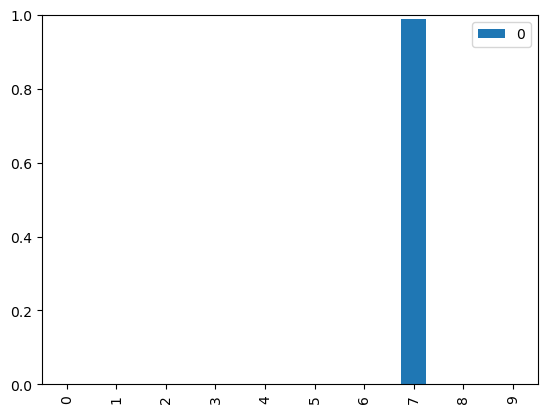

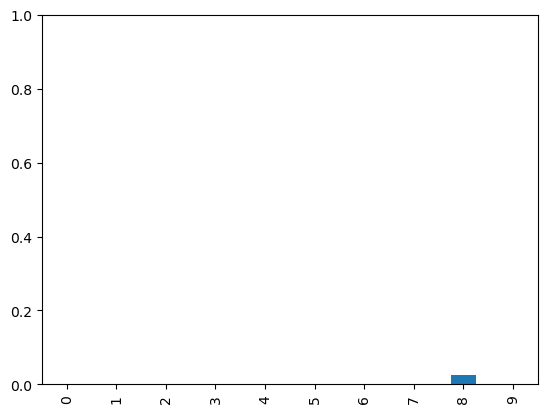

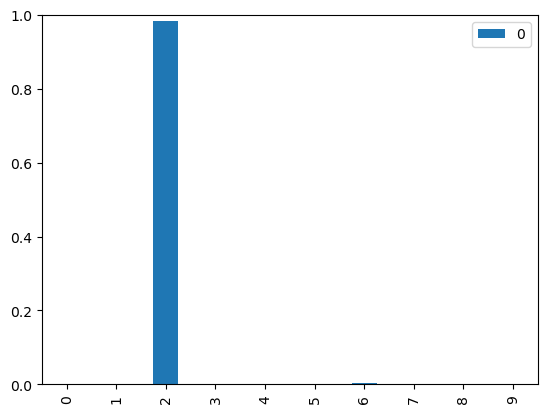

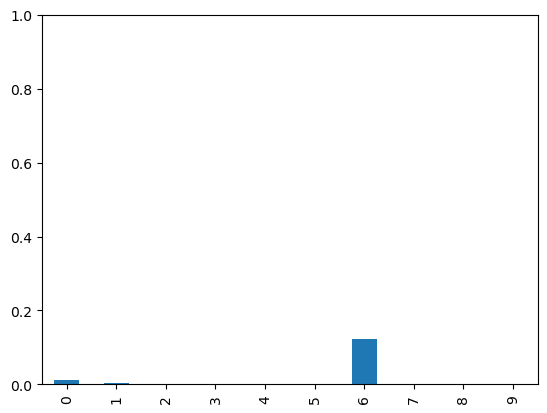

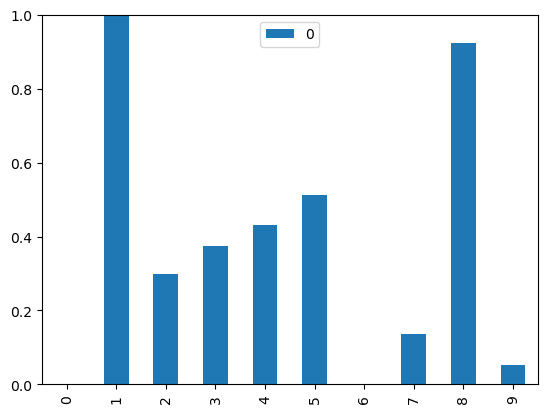

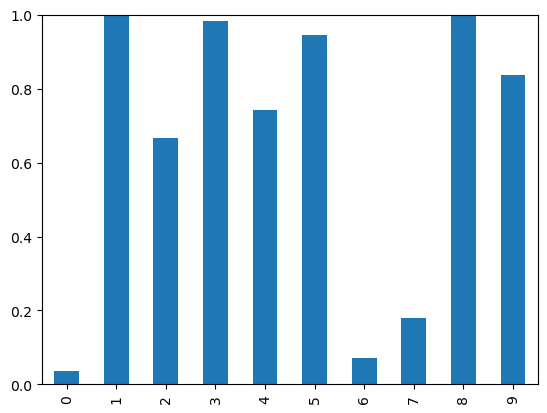

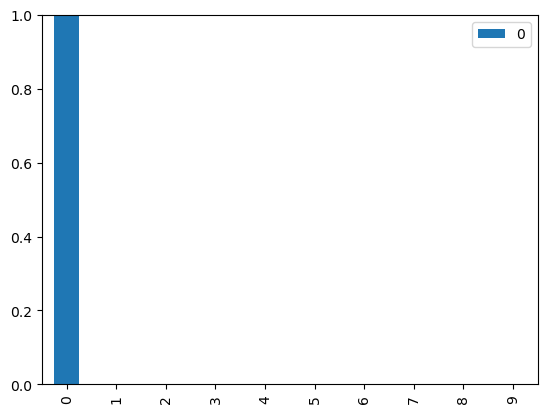

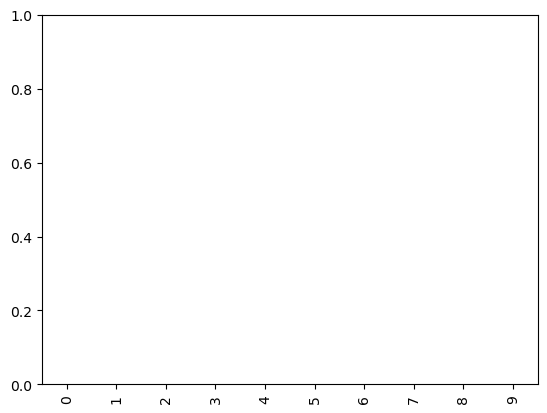

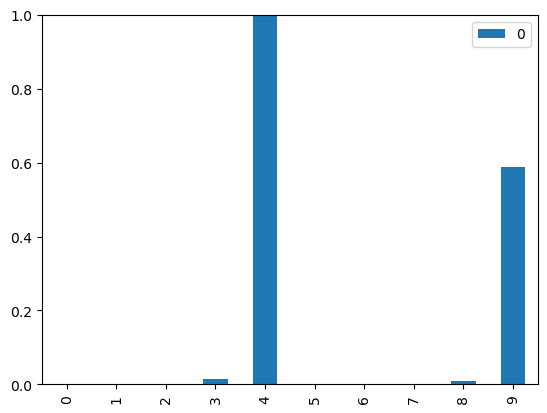

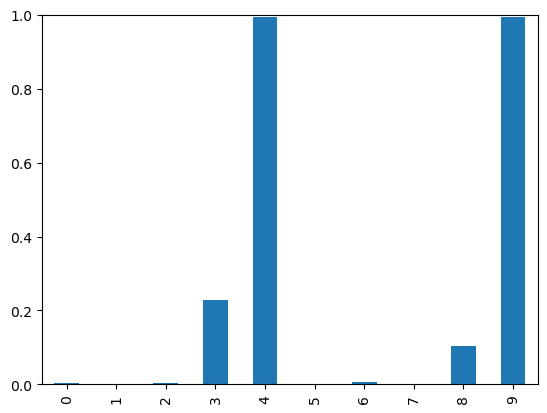

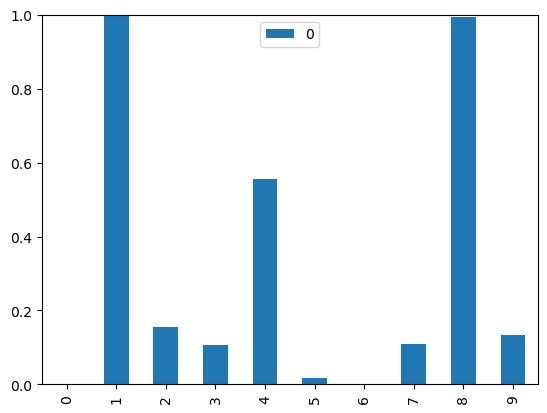

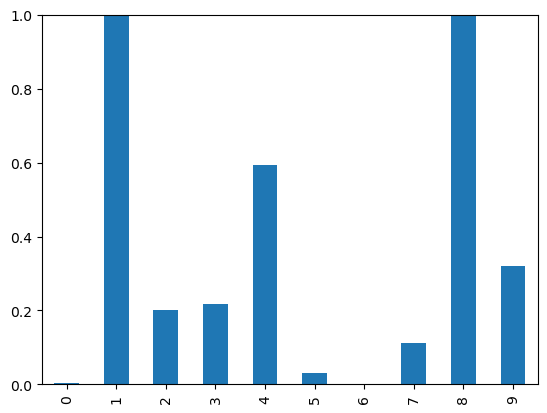

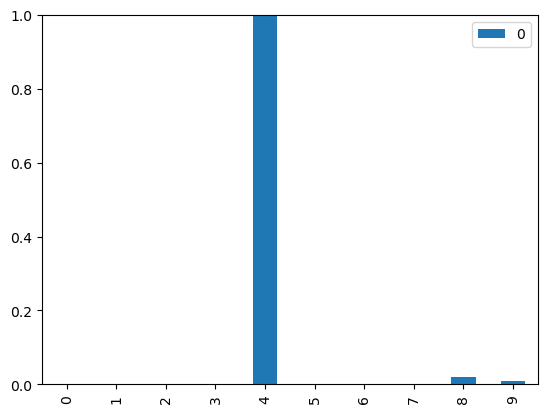

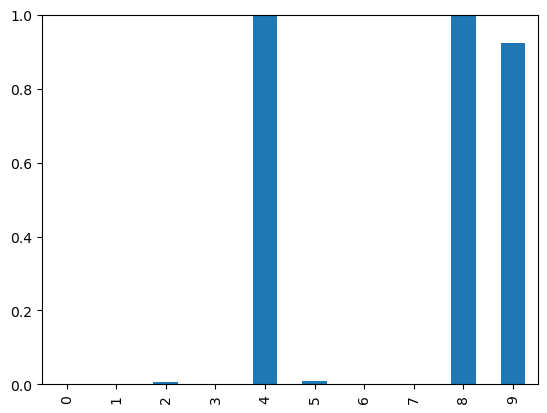

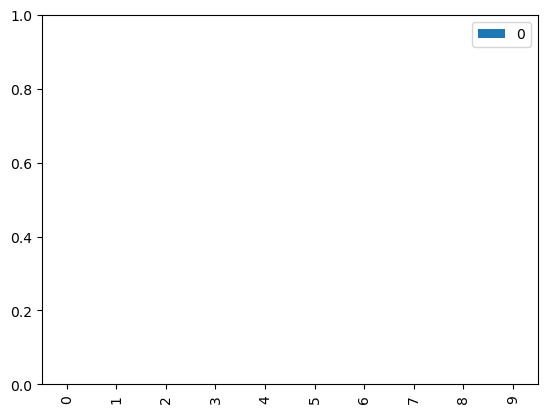

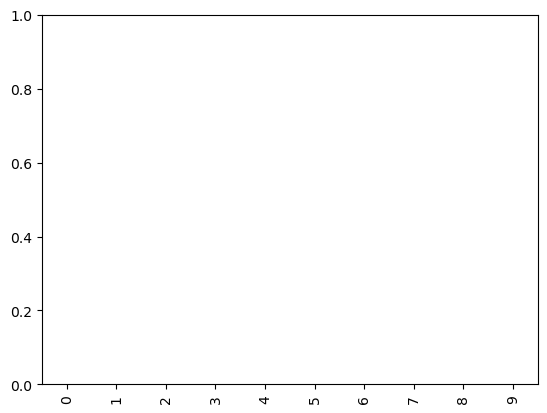

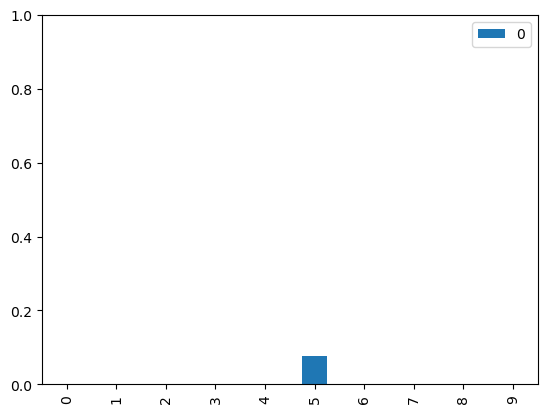

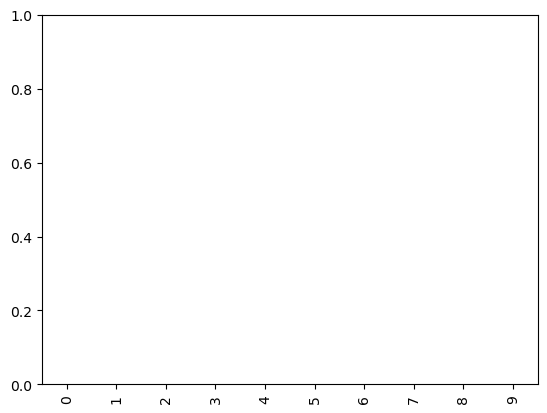

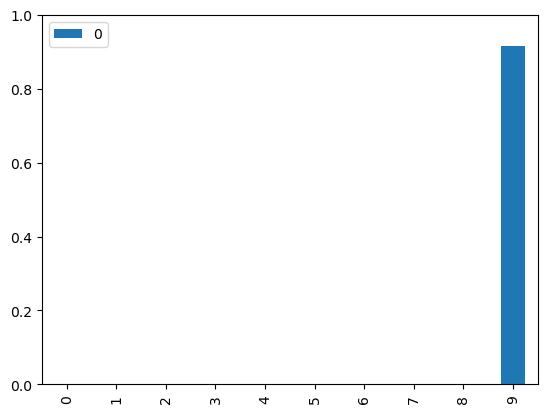

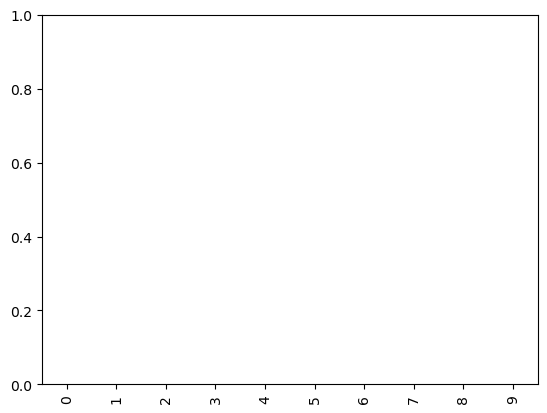

In [14]:
import torchattacks
import numpy as np
from IPython.display import display

C.eval()

attack = torchattacks.DeepFool(C, steps=50, overshoot=0.02)

counter = 0
for label, image_data_tensor, target_tensor in mnist_test_dataset:
    print("-----------------------")
    print("Iteration {}".format(counter))
    answer = C.forward_train(image_data_tensor.clone().detach().view(1,1,28,28))
    answer_new = answer.detach().numpy()
    _, idx = torch.max(answer.unsqueeze(0).clone().detach(), dim=1)
    
    pandas.DataFrame(answer_new).plot(kind='bar', legend=True, ylim=(0,1))

    adv_images = attack(image_data_tensor.clone().detach().view(1,1,28,28), idx)

    adv_answer = C.forward_train(adv_images)
    #print(adv_answer)
    pandas.DataFrame(adv_answer.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

    numpy_adv = adv_images.squeeze(0).squeeze(0).numpy()
    numpy_real = image_data_tensor.clone().detach().view(1,1,28,28).squeeze(0).squeeze(0).numpy()
    
    # Convert the NumPy array to a PIL image
    image_adv = Image.fromarray((numpy_adv * 255).astype(np.uint32)).convert('RGB')
    image_real = Image.fromarray((numpy_real * 255).astype(np.uint32)).convert('RGB')

    #image_adv.show("adv")
    #imshow(np.asarray(image_real))
    display(image_real)
    print("Real Prediction")
    print(torch.topk(answer,3))
    display(image_adv)
    print("Adversarial Prediction")
    print(torch.topk(adv_answer,3))
    counter+=1
    if counter==10:
        break

